- SRCNN - Super Resolution Convolutional Neural netrwork
  - 최초의 cnn 기반 초해상도 모델
  - 입력 이미지를 업샘플링 후 cnn을 적용해서 고해상도 이미지를 생성
  - 학습과정이 단순하지만 성능이 비교적 제한
- GAN 기반 모델(SRGANm ESRGAN)
  - 생성적 적대 신경망(GAN)을 사용해서 초해상도를 학습
  - 생성자와 판별자를 경쟁적으로 학습시켜 더 세밀하고 사실적인 결과를 얻음
  - 최근의 초해상도 연구에서 가장 많이 사용  


- SRCNN VS GAN 기반 모델 비교
  - 비교항목   |       SRCNN                   |           GAN
  -  구조      |     단순한 CNN                |          생성자 + 판별자
  -  속도      |     빠름                      |          느림
  - 해상도 개선|     비교적 단순한 업스케일링  |        디데일까지 세밀한 초해상도
  - 학습방식   |      L2 손실(MSE) 기반        |        GAN + Peceptual Loss

SRCNN 수퍼 해상도 코드

In [54]:
# DIV2K 데이셋 다운로드
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_test_HR.zip

--2025-01-31 11:32:09--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2025-01-31 11:32:09--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  74.6MB/s    in 57s     

2025-01-31 11:33:07 (58.6 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]

--2025-01-31 11:33:07--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Resolving data.vision.ee.ethz.ch

In [55]:
!unzip /content/DIV2K_train_HR.zip

Archive:  /content/DIV2K_train_HR.zip
   creating: DIV2K_train_HR/
  inflating: DIV2K_train_HR/0103.png  
  inflating: DIV2K_train_HR/0413.png  
  inflating: DIV2K_train_HR/0031.png  
  inflating: DIV2K_train_HR/0660.png  
  inflating: DIV2K_train_HR/0126.png  
  inflating: DIV2K_train_HR/0793.png  
  inflating: DIV2K_train_HR/0764.png  
  inflating: DIV2K_train_HR/0550.png  
  inflating: DIV2K_train_HR/0437.png  
  inflating: DIV2K_train_HR/0374.png  
  inflating: DIV2K_train_HR/0755.png  
  inflating: DIV2K_train_HR/0614.png  
  inflating: DIV2K_train_HR/0646.png  
  inflating: DIV2K_train_HR/0371.png  
  inflating: DIV2K_train_HR/0312.png  
  inflating: DIV2K_train_HR/0108.png  
  inflating: DIV2K_train_HR/0556.png  
  inflating: DIV2K_train_HR/0794.png  
  inflating: DIV2K_train_HR/0722.png  
  inflating: DIV2K_train_HR/0780.png  
  inflating: DIV2K_train_HR/0555.png  
  inflating: DIV2K_train_HR/0439.png  
  inflating: DIV2K_train_HR/0396.png  
  inflating: DIV2K_train_HR/0666.png

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


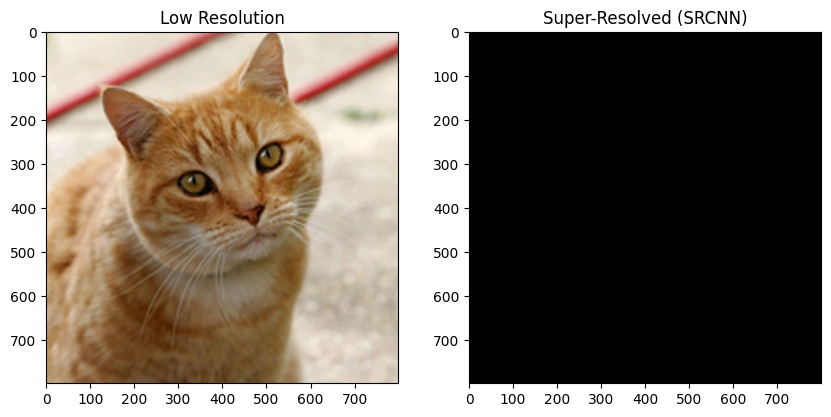

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import matplotlib.pyplot as plt

def build_srcnn():
    model = keras.Sequential([
        layers.Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=(None, None, 3)),
        layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
        layers.Conv2D(3, (5, 5), activation='linear', padding='same')  # Output은 RGB 3채널
    ])
    return model

import glob
def load_train_data(img_path ='/content/DIV2K_train_HR/*.png'):
  images = []
  files = glob.glob(img_path)
  for file in files:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128), interpolation=cv2.INTER_CUBIC)  # 크기통일
    images.append(img / 255.0)
  images = np.array(images)
  low_res = np.array([cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC) for img in images])  # 저해상도 생성
  low_res = np.array([cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC) for img in low_res])  # 다시 업샘플링
  return low_res, images  # (입력, 정답)

# 학습 데이터 준비
x_train, y_train = load_train_data()

# 모델 생성 및 컴파일
srcnn = build_srcnn()
srcnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# 모델 학습
srcnn.fit(x_train, y_train, epochs=10, batch_size=8, validation_split=0.1)

# 모델 저장
srcnn.save("srcnn_trained.h5")


# # 결과 시각화
# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.title("Low Resolution")
# plt.imshow(low_res_img[0])
# plt.subplot(1,2,2)
# plt.title("Super-Resolved (SRCNN)")
# plt.imshow(np.clip(high_res_img, 0, 1))
# plt.show()



In [ ]:
# 모델 불러오기

In [51]:
# 이미지 가져오기
import requests
from PIL import Image
from io import BytesIO
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/800px-Cat03.jpg'
# 이미지 다운로드
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
# 저해상도 변환
low_res = img.resize((img.width //4, img.height // 4), Image.BICUBIC)
# 원래 크기로 복원
low_res = low_res.resize((img.width, img.height), Image.BICUBIC)
low_res.save('low_res.jpg')